In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import numpy as np
import copy
import scipy

c:\msc_project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
G = nx.Graph()

In [3]:
# read the data file and convert it to a dictionary
# dictionary = {testcase ID (int): {"testcase": testcase name, "exec_line": list of executed lines}}
D = dict()
key_count = 0
previous_test_case = ''
with open('dataset/assertj-core1_2013.txt') as f:
    for line in f:
        l_line = line.rstrip().split("\t")
        if previous_test_case != l_line[1]:
            previous_test_case = l_line[1]
            key_count += 1
        if key_count in D:
            D[key_count]["exec_line"].append(l_line[2]+l_line[3])
        else:
            D[key_count] = {"testcase": l_line[1], "exec_line":[l_line[2]+l_line[3]]}



dict_items([((1, 2), 26), ((1, 3), 62), ((1, 4), 62), ((1, 5), 12), ((1, 6), 16), ((1, 7), 12), ((1, 9), 16), ((1, 10), 19), ((1, 11), 16), ((1, 12), 15), ((1, 13), 12), ((1, 14), 17), ((1, 15), 12), ((1, 16), 16), ((1, 17), 15), ((1, 18), 14), ((1, 19), 27), ((1, 20), 26), ((1, 21), 12), ((1, 22), 10), ((1, 23), 8), ((2, 3), 25), ((2, 4), 25), ((2, 5), 26), ((2, 6), 25), ((2, 7), 25), ((2, 9), 26), ((2, 10), 10), ((2, 11), 13), ((2, 12), 12), ((2, 13), 26), ((2, 14), 13), ((2, 15), 12), ((2, 16), 12), ((2, 17), 12), ((2, 18), 13), ((2, 19), 10), ((2, 20), 10), ((2, 21), 12), ((2, 22), 10), ((2, 23), 5), ((3, 4), 62), ((3, 5), 12), ((3, 6), 15), ((3, 7), 12), ((3, 9), 16), ((3, 10), 19), ((3, 11), 15), ((3, 12), 15), ((3, 13), 12), ((3, 14), 16), ((3, 15), 12), ((3, 16), 16), ((3, 17), 15), ((3, 18), 12), ((3, 19), 26), ((3, 20), 26), ((3, 21), 12), ((3, 22), 10), ((3, 23), 8), ((4, 5), 12), ((4, 6), 15), ((4, 7), 12), ((4, 9), 16), ((4, 10), 19), ((4, 11), 15), ((4, 12), 15), ((4, 13)

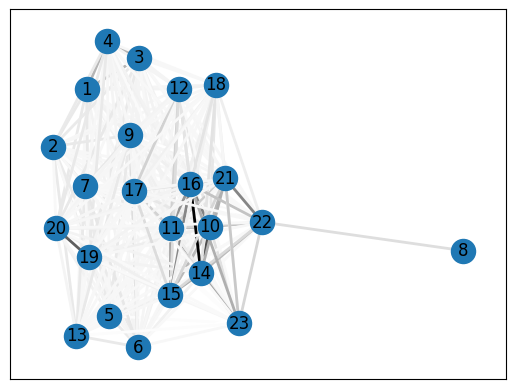

In [4]:
# Create a graph
# networkx's document is refered.
# https://networkx.org/documentation/stable/tutorial.html

# add nodes
for i in D:
    # print(i)
    # print(D[i]["testcase"])
    G.add_node(i)

# add weighted edge: the number of common executed lines is the weight of edge.
for i in range(1, len(D)+1):
    for j in range(i+1, len(D)+1):
        weight = len(set(D[i]["exec_line"]) & set(D[j]["exec_line"]))
        if weight != 0:
            G.add_weighted_edges_from([(i,j,weight)])

edges = G.edges(data=True)
weight_set = ()

# draw the graph with colored edges according to the weight.
# the code "edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())"
# refers to : https://www.tutorialspoint.com/colouring-the-edges-by-weight-in-networkx-matplotlib
print(nx.get_edge_attributes(G, 'weight').items())
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw_networkx(G,width=2, edge_color=weights, edge_cmap=plt.cm.Greys)
               
               
    

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 109.89it/s]


[[-0.21842822 -7.0774937 ]
 [ 0.4534503  -7.421534  ]
 [ 0.10083244 -6.694626  ]
 [-0.09717571 -4.9632497 ]
 [ 2.1418688  -4.824768  ]
 [ 1.2726165  -5.909452  ]
 [ 2.6021063  -5.2211556 ]
 [ 0.78563464 -5.1436954 ]
 [-0.72000426 -6.498527  ]
 [-1.648899   -4.929412  ]
 [-0.23842756 -5.8447337 ]
 [-1.217698   -5.488084  ]
 [-0.7532782  -4.8065143 ]
 [ 2.0814552  -4.63037   ]
 [ 2.3364303  -5.5473747 ]
 [ 2.440558   -5.7655263 ]
 [ 0.2637735  -4.44499   ]
 [-0.7398042  -5.807196  ]
 [-0.22654805 -4.9714165 ]
 [-1.0587242  -4.0896235 ]
 [ 2.3742003  -6.226137  ]
 [ 0.2936567  -5.6513953 ]
 [ 2.1741273  -6.272684  ]]


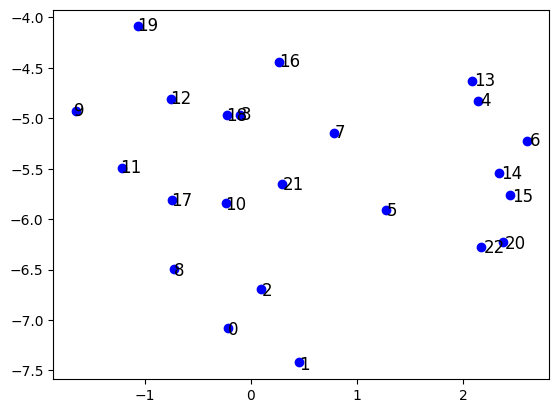

In [5]:
# Create Embedding
# https://github.com/eliorc/node2vec
# for destination in G.neighbors(1):
#     print(destination)
#     if G[1][destination].get("weight"):
#         weight = G[1][destination].get("weight", 1)
#         print("weight between 1 and destination is:", weight)
        
node2vec = Node2Vec(G, dimensions=10)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
embeddings = np.array([model.wv[x-1] for x in G.nodes])

# Save embeddings for later use
model.wv.save_word2vec_format("assertj_top2013_embedding.txt")

# reduce the dimension using t-SNE
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)
print(embeddings_2d)
# visualise the embeddings
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
# plt.show()

for i in range(len(embeddings_2d)):
    x = embeddings_2d[i][0]
    y = embeddings_2d[i][1]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)

plt.show()

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

In [6]:
# implement NLC(i)
# nx.draw_networkx(copy_G_for_k_shell)
print("original graph", list(G))

def getKShellDict(G):
    copy_G_for_k_shell = copy.deepcopy(G)
    k_shell_dict = dict()
    k_shell_value = 0

    each_k_shell_count = 0 
    finish_flg = False
    # calculate k-shell value for each node
    # TODO This is a weighted graph. Is it enough to multiple the weights to the degree to get k-shell value?


    while not finish_flg:
        each_value_finish_flg = False
        while not each_value_finish_flg:
            each_k_shell_count = 0
            loop_count = 0
            for i in range(0, len(list(G))):
        
                if G.degree(weight='weight')[list(G)[i]] <= k_shell_value:
                    each_k_shell_count += 1
                    k_shell_dict[list(G)[i]] = k_shell_value
                    copy_G_for_k_shell.remove_node(list(G)[i])
                    i += 1
            G = copy.deepcopy(copy_G_for_k_shell)
            if len(list(G.nodes)) == 0:
                finish_flg = True

            if each_k_shell_count == 0:
                each_value_finish_flg = True
                k_shell_value += 1
    return k_shell_dict

# return the set of nodes which are in the theid-level neighborhoods of node i
def thirdLevelNeighbors(G, i):
    first_neighbors = set([n for n in G.neighbors(i)])
    print("first neighbor", first_neighbors)
    result_neighbors = set()
    result_neighbors = result_neighbors | first_neighbors
    
    second_neighbors = set()
    for j in first_neighbors:
        second_neighbors = first_neighbors | set([n for n in G.neighbors(j)])
    print("second neighbors:", second_neighbors)

    third_neighbors = set()
    for j in second_neighbors:
        third_neighbors = third_neighbors | set([n for n in G.neighbors(j)])

    return first_neighbors | second_neighbors | third_neighbors


# calculate NLC of node n
def getNLC(G, n):
    k_shell = getKShellDict(G)
    neighbors = thirdLevelNeighbors(G,n)

    node2vec_dict = dict()

    with open("assertj_top2013_embedding.txt") as f:
        for line in f:
            data  =  line.rstrip().split(" ")
            float_data = []
            for i in data:
                float_data.append(float(i))
            node2vec_dict[int(float_data[0])] = float_data[1:]

    print("node2vec_dect", node2vec_dict)
    print(node2vec_dict[11])


    NLC = 0


    for j in neighbors:
        x1 = node2vec_dict[n]
        x2 = node2vec_dict[j]
        ed = scipy.spatial.distance.euclidean(node2vec_dict[n], node2vec_dict[j])
        
        NLC = NLC + k_shell[n]* np.exp(-ed)

    return NLC


print(thirdLevelNeighbors(G, 11))
print(getNLC(G, 11))

result = ""
for node in list(G):
    nlc = getNLC(G, node)
    result += (str(node) + " " + str(nlc) + "\n")

with open("assertj_top2013_nlc.txt", "w") as f:
    f.write(result)

original graph [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
first neighbor {1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
second neighbors: {1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
first neighbor {1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
second neighbors: {1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
node2vec_dect {23: [0.072583646, -0.17810014, 0.2862232, -0.15436676, 0.283148, 0.068546705, 0.727014, 0.45386645, -0.40131548, 0.07853604], 14: [0.119941466, -0.112774394, 0.49834442, 0.06446622, 0.1669833, -0.08484412, 0.6432406, 0.477183, -0.41923296, -0.027177967], 16: [0.276779, -0.10124743, 0.36916426, 0.011234589, 0.19228528, -0.0054215533, 0.6475927, 0.4803414, -0.49957436, -0.08299617], 10: [0.16150236, -0.05219754, 0.4813